In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

In [5]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm.notebook import tqdm

from simulator import simulator


In [6]:
# Define - Dataset, Model, calc_acc, dataset_creation

class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, samples, labels):
        
        super(Dataset, self).__init__()
        
        self.create_dataset(samples, labels)
        
    def create_dataset(self, all_samples, all_labels):
        
        self.dataset = []
        
        for sample, label in zip(all_samples, all_labels):
            self.dataset.append((torch.tensor(sample).float(), torch.tensor(label).float()))

    def __getitem__(self, index):
                                        
        return self.dataset[index]                            
        
    def __len__(self):
        
        return len(self.dataset)


    
class MLP(nn.Module):

    def __init__(self, lr, num_in, num_out):
        super().__init__()
        
        self.lr = lr
        
        self.network = nn.Sequential(nn.Linear(num_in, 32),
                                     nn.ReLU(),
                                     nn.Linear(32, 32),
                                     nn.ReLU(),
                                     nn.Linear(32, num_out),
                                     nn.Sigmoid(),
                                     nn.Softmax())
        
#         self.optimizer = torch.optim.Adam(self.parameters(), lr = self.lr)

    def forward(self, x):
        return self.network(x)
    
#     def init_optimizer(self):
#         self.optimizer = torch.optim.Adam(self.parameters(), lr = self.lr)

#     def objective(self, preds, labels):
#         obj = nn.MSELoss()
#         return obj(preds, labels)
    
    
    
def calculate_accuracy(all_preds, all_labels):

    accuracy = 0
    for i, (pred, label) in enumerate(zip(all_preds, all_labels)):
        
        pred = np.argmax(pred)
        
        if(pred == label):
            accuracy = accuracy + 1
    
    return accuracy / (i + 1)



def ballsINTObins(m, n):
    
    if m==0:
        return np.zeros((1, n))
    
    if n==1:
        return np.asarray([m])
    
    all_rest = []
    for i in range(m+1):
        rest = ballsINTObins(m-i, n-1)
        all_rest.append(np.c_[np.ones(rest.shape[0])*i, rest])
    
    result = np.concatenate(all_rest, axis=0)
    return result

In [7]:
# User assigined parameters

class Parameters:
    def __init__(self, air_trans_file, atm_dist_ratio, air_RI, basis_func_file,
                 num_substances, spectra_file, substances_emit_file):
        self.air_trans_file = air_trans_file
        self.atm_dist_ratio = atm_dist_ratio
        self.air_RI = air_RI
        self.basis_func_file = basis_func_file
        self.num_substances = num_substances
        self.spectra_file = spectra_file
        self.substances_emit_file = substances_emit_file
        
        
        
parameters = Parameters(air_trans_file='./data/Test 2 - 21 Substances/Air transmittance.xlsx',
                        atm_dist_ratio=0.11,
                        air_RI=1,
                        basis_func_file='./data/Test 2 - 21 Substances/Basis functions.xlsx',
                        num_substances=3,
                        spectra_file='./data/Test 2 - 21 Substances/spectra.xlsx',
                        substances_emit_file='./data/Test 2 - 21 Substances/substances.xlsx')



In [10]:
# Init dataset

# Enviroment related parameters
temp_K = 293.15 # Environmental temperature in K
air_trans = np.array(pd.read_excel(parameters.air_trans_file, header=None))
air_trans = air_trans[:, 1:]
atm_dist_ratio = parameters.atm_dist_ratio # Atomsphere distance ratio
air_RI = parameters.air_RI # Refractive index of air

# Sensor related parameters
basis_funcs = np.array(pd.read_excel(parameters.basis_func_file, header=None))
basis_funcs = basis_funcs[:, 1:]

# Substance related parameters
num_substances = parameters.num_substances
spectra = np.array(pd.read_excel(parameters.spectra_file, header=None))
substances_emit = np.array(pd.read_excel(parameters.substances_emit_file, header=None))
substances_emit = substances_emit[:, 0:parameters.num_substances]
# Material mixture proportion
mat_proportion = ballsINTObins(10, parameters.num_substances).transpose() / 10

data = []
labels = []
for i in range(mat_proportion.shape[1]):
    weights = mat_proportion[:, i]
    mat_em = np.average(substances_emit, weights=weights, axis=1)
    mat_em = np.expand_dims(mat_em, 1)
    out = simulator(spectra, mat_em, temp_K, air_trans, atm_dist_ratio, air_RI, basis_funcs)
    data.append(out)
    labels.append(weights)


In [34]:
# Training parameters

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(28)

criterion = nn.MSELoss()

dataset = Dataset(data, labels)

batch_size = len(data) // 10
train_percentage = 0.8
learning_rate = 1e-3

optimizer = 

epoch = 500

k = 5
kfold = KFold(n_splits=k, shuffle=True)

train_size = int(train_percentage * len(data))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [11]:
def train_epoch(model, device, dataloader, criterion, optimizer):
    train_loss = 0
    model.train()
    for samples, labels in dataloader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * samples.size(0)
        
    return train_loss



def valid_epoch(model, device, dataloader, criterion, optimizer):
    valid_loss = 0
    model.eval()
    for samples, labels in dataloader:
        samples, labels = samples.to(device), labels.to(device)
        output = model(samples)
        loss = criterion(output, labels)
        valid_loss += loss.item() * samples.size(0)
        
    return valid_loss

In [ ]:
history = {'train_loss': [], 'test_loss': []}

for fold, (train_ids, valid_ids) in enumerate(kfold.split(train_dataset)):
    print(f'FOLD {fold + 1}')
    print('--------------------------------')
    train_subsampler = SubsetRandomSampler(train_ids)
    valid_subsampler = SubsetRandomSampler(valid_ids)
    train_loader = DataLoader(train_dataset, batch_size=parameters.batch_size, sampler=train_subsampler)
    valid_loader = DataLoader(train_dataset, batch_size=parameters.batch_size, sampler=valid_subsampler)
    
    model = MLP(lr=learning_rate, num_in=basis_funcs.shape[1], num_out=num_substance)
    model.to(device)
    
    for i in range(epoch):
        

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

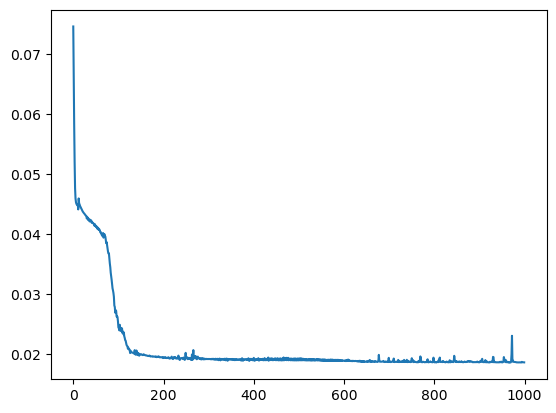

Target:  [ 0.00  0.00  1.00]
Predict: [ 0.21  0.21  0.58] 

Target:  [ 0.00  0.10  0.90]
Predict: [ 0.21  0.21  0.58] 

Target:  [ 0.00  0.20  0.80]
Predict: [ 0.21  0.21  0.58] 

Target:  [ 0.00  0.30  0.70]
Predict: [ 0.21  0.24  0.56] 

Target:  [ 0.00  0.40  0.60]
Predict: [ 0.17  0.35  0.47] 

Target:  [ 0.00  0.50  0.50]
Predict: [ 0.16  0.42  0.42] 

Target:  [ 0.00  0.60  0.40]
Predict: [ 0.17  0.46  0.37] 

Target:  [ 0.00  0.70  0.30]
Predict: [ 0.21  0.56  0.23] 

Target:  [ 0.00  0.80  0.20]
Predict: [ 0.21  0.58  0.21] 

Target:  [ 0.00  0.90  0.10]
Predict: [ 0.21  0.58  0.21] 

error: 0.19405053372523098


In [32]:
# Train

# Parameters
batch_size = len(data) // 10
train_percentage = 0.8
learning_rate = 1e-3

dataset = Dataset(data, labels)

train_size = int(train_percentage * len(data))
test_size = len(dataset) - train_size

# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# temp for test
train_dataset, test_dataset = dataset, dataset

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)


model = MLP(lr=learning_rate, num_in=basis_funcs.shape[1], num_out=num_substance)
# criterion = torch.nn.BCELoss()
criterion = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = lr)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
model.train()
epoch = 1000
training_loss = []
for ep in tqdm(range(epoch), desc="Training"):

    epoch_loss = 0
    for i, (sample, label) in enumerate(train_dataset):
        # Forward pass
        preds = model(sample)
        # Compute Loss
        loss = model.objective(preds, label)

        epoch_loss = epoch_loss + loss.item()

        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()

    epoch_loss = epoch_loss / (i + 1)

    training_loss.append(epoch_loss)


plt.figure()
plt.plot(training_loss)
plt.show()


model.eval()
all_labels, all_preds = [], []

for i, (sample, label) in enumerate(test_dataset):

    preds = model(sample)

    all_preds.append(preds.detach().numpy())
    all_labels.append(label.numpy())

all_labels = np.asarray(all_labels)
all_preds = np.asarray(all_preds)


#     to_print = np.asarray([all_labels, all_preds])
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
for i in range(10):
    print("Target: ", all_labels[i, :])
    print("Predict:", all_preds[i, :], '\n')



error = 0
for i in range(all_labels.shape[0]):
    error = error + np.linalg.norm(all_labels[i, :] - all_preds[i, :])

print("error:", error/all_labels.shape[0])

In [ ]:
# Run

def percentage_test(x, y):
    
    batch_size = 20
    
    dataset = Dataset(x, y)
    
#     x = torch.FloatTensor(x)
#     y = torch.FloatTensor(y)
    
    train_size = int(0.8 * len(x))
    test_size = len(dataset) - train_size
    
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = False)


    model = MLP()
    # criterion = torch.nn.BCELoss()
    criterion = torch.nn.MSELoss()
    lr = 1e-4
    # optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    model.train()
    epoch = 300
    training_loss = []
    for ep in tqdm(range(epoch), desc="Training"):
        
        epoch_loss = 0
        for i, (sample, label) in enumerate(train_dataset):
            # Forward pass
            preds = model(sample)
            # Compute Loss
            loss = model.objective(preds, label)
        
            epoch_loss = epoch_loss + loss.item()
            
            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()
        
        epoch_loss = epoch_loss / (i + 1)
    
        training_loss.append(epoch_loss)
    

    plt.figure()
    plt.plot(training_loss)
    plt.show()


    model.eval()
    all_labels, all_preds = [], []
    
    for i, (sample, label) in enumerate(test_dataset):
        
        preds = model(sample)
        
        all_preds.append(preds.detach().numpy())
        all_labels.append(label.numpy())
    
    all_labels = np.asarray(all_labels)
    all_preds = np.asarray(all_preds)
    
#     to_print = np.asarray([all_labels, all_preds])
    
    for i in range(100):
        print("Target: ", all_labels[i, :])
        print("Predict:", all_preds[i, :], "\n")
    
    
    
    error = 0
    for i in range(all_labels.shape[0]):
        error = error + np.linalg.norm(all_labels[i, :] - all_preds[i, :])

    print("error:", error/all_labels.shape[0])
    return



if __name__ == '__main__':
    # Enviroment related parameters
    temp_K = 293.15 # Environmental temperature in K
    air_trans = np.array(pd.read_excel('./data/Test 2 - 21 Substances/Air transmittance.xlsx', header=None))
    air_trans = air_trans[:, 1:]
    atm_dist_ratio = 0.11 # Atomsphere distance ratio
    air_RI = 1 # Refractive index of air

    # Sensor related parameters
    basis_funcs = np.array(pd.read_excel('./data/Test 2 - 21 Substances/Basis functions.xlsx', header=None))
    basis_funcs = basis_funcs[:, 1:]
    
    # Substance related parameters
    spectra = np.array(pd.read_excel('./data/Test 2 - 21 Substances/spectra.xlsx', header=None))
    substances_emit = np.array(pd.read_excel('./data/Test 2 - 21 Substances/substances.xlsx', header=None))
    substances_emit = substances_emit[:, [4, 16]]

    mat_proportion = np.array(pd.read_excel('./data/Test 2 - 21 Substances/proportion_NN_test.xlsx', header=None)) # Material mixture proportion

    data = []
    labels = []
    for i in range(mat_proportion.shape[1]):
        weights = mat_proportion[:, i]
        mat_em = np.average(substances_emit, weights=weights, axis=1)
        mat_em = np.expand_dims(mat_em, 1)
        out = simulator(spectra, mat_em, temp_K, air_trans, atm_dist_ratio, air_RI, basis_funcs)
        data.append(out)
        labels.append(weights)


    percentage_test(data, labels)